In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard.notebook

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# set up tensorboard log directory
logdir="tf_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(logdir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# need the following to successfully run. 
# Otherwise there will be cuDNN error in training 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
sess.as_default()

W0417 17:28:51.805974 139979614009088 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


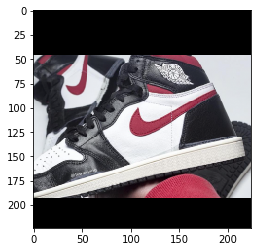

In [3]:
# define dataloader and preprocessing
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 256, 256)
    image = tf.image.random_crop(image, (224, 224, 3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = image/255  # normalize to [0,1] range
    return image
path = "/home/nan/sneaker_ai/screened_data/air_jordan_1/air_jordan_1_362.png"
plt.imshow(load_and_preprocess_image(path))

W0417 17:28:52.090071 139979614009088 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/nan/sneaker_ai/screened_data/air_jordan_1/air_jordan_1_299.jpg


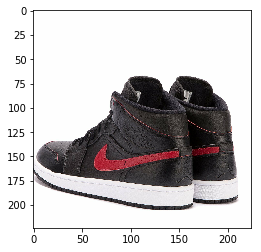

In [4]:
# test random data loaders
import random
train_df = pd.read_csv("train_df.csv")
indx = random.randint(0, len(train_df))
path = train_df.iloc[indx, 1]
print(path)
plt.imshow(load_and_preprocess_image(path))

In [5]:
# set up datasets
from sklearn.utils import shuffle
train_df = shuffle(train_df)
train_image_paths = train_df.loc[:, "Image_File"].tolist()
train_image_labels = train_df.loc[:, "Label"].tolist()

test_df = pd.read_csv("test_df.csv")
# test_df = shuffle(test_df)
test_image_paths = test_df.loc[:, "Image_File"].tolist()
test_image_labels = test_df.loc[:, "Label"].tolist()
# covertion between class names and model outputs
label_names = ["AJ "+str(i) for i in range(1,24)]
label_to_index = dict((name, index) 
                      for index, name in enumerate(label_names))

train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

train_ds = train_ds.map(load_and_preprocess_from_path_label)
test_ds = test_ds.map(load_and_preprocess_from_path_label)

In [6]:
# specify batch size and buffering for datasets
BATCH_SIZE = 64

# # Setting a shuffle buffer size as large as the dataset ensures that the data is
# # completely shuffled.
# train_ds = train_ds.apply(
#   tf.data.experimental.shuffle_and_repeat(buffer_size=len(train_df)))
# do the following to save some ram, otherwise training will stop
train_ds = train_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=256))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# do the following to save some ram, otherwise training will stop
test_ds = test_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=256))
# test_ds = test_ds.apply(
#   tf.data.experimental.shuffle_and_repeat(buffer_size=len(test_df)))
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [7]:
# import mobilenet v2 model
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224,224, 3), include_top=False)
# mobile_net.trainable=False
mobile_net.trainable=True

In [8]:
# MobileNetV2: https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
# imagenet.utils: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
# mobile net expects prepocessed input ranging from -1 to 1
def change_range(image,label):
    return 2*image-1, label

train_ds = train_ds.map(change_range)
test_ds = test_ds.map(change_range)

In [ ]:
# add fc layers after mobilenet for transfer learning
model = tf.keras.Sequential([
    mobile_net,
    # take an average of each channel so that the model woks with different input sizes
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
#     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_names), activation=tf.nn.softmax)])

In [ ]:
# configure model optimizer, loss
# model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-6), 
#               loss=tf.keras.losses.sparse_categorical_crossentropy,
#               metrics=["accuracy"])

# learning_rate=5e-6 was tuned for batch size 16
# larger batch allows for greater learning rate
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 23)                2

In [ ]:
%tensorboard --logdir {logdir}

In [ ]:
# model training
num_epochs = 60
training_history = model.fit(train_ds, epochs=num_epochs, 
                             validation_data=test_ds,
                             callbacks=[tensorboard_callback],
#                              verbose=2,
                            )

Epoch 1/60
89/89 [==============================] - 130s 1s/step - loss: 3.6081 - accuracy: 0.0444 - val_loss: 3.1491 - val_accuracy: 0.0618
Epoch 2/60
89/89 [==============================] - 78s 882ms/step - loss: 3.2230 - accuracy: 0.0692 - val_loss: 3.0690 - val_accuracy: 0.0808
Epoch 3/60
89/89 [==============================] - 78s 873ms/step - loss: 3.1143 - accuracy: 0.0813 - val_loss: 3.0042 - val_accuracy: 0.1039
Epoch 4/60
89/89 [==============================] - 80s 898ms/step - loss: 3.0366 - accuracy: 0.0980 - val_loss: 2.9361 - val_accuracy: 0.1393
Epoch 5/60
89/89 [==============================] - 77s 870ms/step - loss: 2.9703 - accuracy: 0.1220 - val_loss: 2.8504 - val_accuracy: 0.1882
Epoch 6/60
89/89 [==============================] - 77s 861ms/step - loss: 2.8682 - accuracy: 0.1634 - val_loss: 2.7467 - val_accuracy: 0.2371
Epoch 7/60
89/89 [==============================] - 77s 860ms/step - loss: 2.7493 - accuracy: 0.2017 - val_loss: 2.6055 - val_accuracy: 0.2921
E

In [ ]:
 sess.close()